# Homework 3: Question 2

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import AdamW, GPT2LMHeadModel, GPT2Tokenizer
from utils.data_loader_gen import process_data, read_data
from utils.evaluate_gen import evaluate_model
from utils.loss import custom_loss
from utils.printing import print_random_samples

/Users/jacob/.pyenv/versions/miniconda3-3.11-24.1.2-0/envs/msai337/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading Data

In [2]:
torch.manual_seed(0)
TEST_MODE = False
train = []
test = []
valid = []

For our approach, we're reading in data in this manner:

```python
[START] <fact> <stem> [A] <choice> [B] <choice> [C] <choice> [D] <choice> [ANSWER] <correct label A, B, C, or D>
```

We're using the `fact` and `stem` along with the choices to predict the label with the answer.

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

In [4]:
train = read_data("data/train_complete.jsonl", tokenizer)
valid = read_data("data/dev_complete.jsonl", tokenizer)
test = read_data("data/test_complete.jsonl", tokenizer)

In [5]:
train_input_ids, train_attention_masks, train_labels = process_data(train)
val_input_ids, val_attention_masks, val_labels = process_data(valid)
test_input_ids, test_attention_masks, test_labels = process_data(test)

In [6]:
BATCH_SIZE = 13

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Training Model

* We're using GPT2, which is a decoder only model.
* We're also using a GPT2 tokenizer, ensuring that the input data is tokenized in a way that the model expects.
* Based on our previous hyperparameter tuning, we have observed that using dropout helps in preventing overfitting. Therefore, we are incorporating a dropout rate of `0.3` in our model.
*  We are using a much smaller learning rate of `1e-5` to ensure more stable and gradual updates to the model weights, which aids in achieving better convergence.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.config.dropout_rate = 0.3
model.train()
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


* For the loss, we're using our own custom loss function that's based on `CrossEntropyLoss`, but it has additional steps to handle padding and magnify the loss of the last token in each sequence.
* We ensure that padding tokens do not contribute to the loss by creating a mask.
* We multiply the loss of the last token by a specified factor, emphasizing the importance of correctly predicting the last token.
* The function calculates the mean loss only over the non-padding tokens.

```python
def custom_loss(outputs, labels, magnification_factor=10):
    loss_fct = CrossEntropyLoss(reduction="none")
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    mask = shift_labels != -100
    loss[:, -1] *= magnification_factor
    loss = (loss * mask).sum() / mask.sum()
    return loss
```

In [8]:
NUM_EPOCHS = 23

In [ ]:
if not TEST_MODE:
    train_losses = []
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        total_train_loss = 0
        model.train()
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):

            input_ids, attention_masks, labels = [b.to(device) for b in batch]
            labels[labels == tokenizer.pad_token_id] = -100

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids, attention_mask=attention_masks, labels=labels
            )
            loss = custom_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                input_ids, attention_masks, labels = [b.to(device) for b in batch]
                labels[labels == tokenizer.pad_token_id] = -100

                outputs = model(
                    input_ids=input_ids, attention_mask=attention_masks, labels=labels
                )
                loss = custom_loss(outputs, labels)
                total_val_loss += loss.item()

        val_accuracy = evaluate_model(valid, model, tokenizer, device)
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(
            f"Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}"
        )
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Validation Accuracy: {val_accuracy}")

In [21]:
if not TEST_MODE:
    losses_df = pd.DataFrame(
        {
            "Epoch": range(1, NUM_EPOCHS + 1),
            "Training Loss": train_losses,
            "Validation Loss": val_losses,
        }
    )
    losses_df = losses_df.melt(id_vars="Epoch", var_name="Loss Type", value_name="Loss")
    losses_df.to_csv("results/gen_losses.csv", index=False)

In [22]:
if TEST_MODE:
    losses_df = pd.read_csv("results/gen_losses.csv")

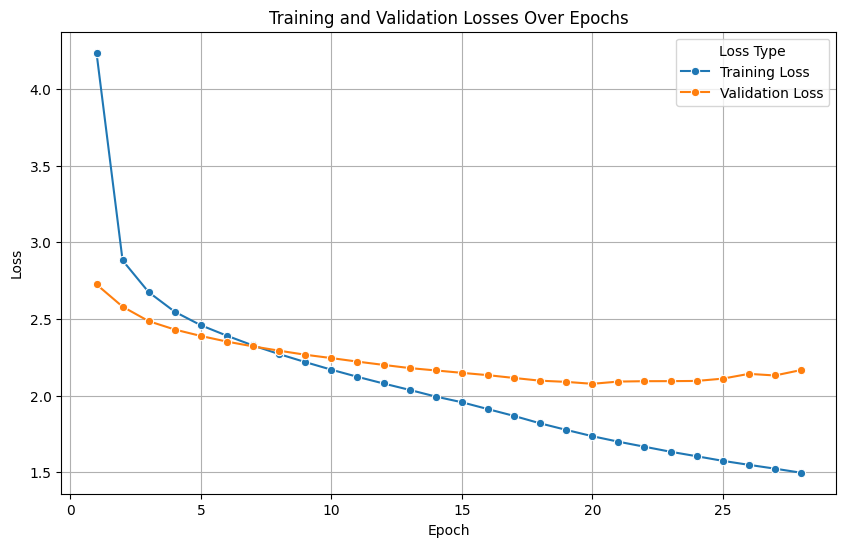

In [23]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=losses_df, x="Epoch", y="Loss", hue="Loss Type", marker="o")
plt.title("Training and Validation Losses Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Loss Type")
plt.grid(True)
plt.show()

* We see that the validation loss starts increasing after around 22 epochs.
* So we'll use early stopping here and save the model's state at 22.

In [12]:
if not TEST_MODE:
    model_save_path = f"model_weights/model_gen_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

Model saved to model_weights/model_gen_epoch_21.pth


## Fine Tuned Accuracies

In [13]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model_wgts = torch.load("model_weights/model_gen_epoch_22.pth")
model.load_state_dict(model_wgts)

<All keys matched successfully>

In [14]:
val_accuracy = evaluate_model(valid, model, tokenizer, device)
test_accuracy = evaluate_model(test, model, tokenizer, device)
print("validation accuracy", val_accuracy)
print("testing accuracy", test_accuracy)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [02:39<00:00,  4.10s/it]

validation accuracy 0.41
testing accuracy 0.412


In [16]:
print_random_samples(valid, model, tokenizer, device)
print("================================")
print_random_samples(train, model, tokenizer, device)

Input text for generation: [START] absorbing sunlight causes objects to heat Absorbing sunlight [A] leaves objects too frosty to handle [B] makes car hoods cool to the touch [C] leaves surfaces and objects unaffected [D] makes the asphalt scorching to bare feet [ANSWER]
Generated answer: C] Cries for help from the gods
Actual answer: D
----
Input text for generation: [START] a stinger is used for defense by a wasp A wasp will use it's stinger [A] if the wasp is flying about unimpeded [B] if a person grabs the wasp [C] if a person ignores the wasp [D] if a wasp is hanging out in it's nest [ANSWER]
Generated answer: A wasp will use it's stinger
Actual answer: B
----
Input text for generation: [START] the Grand Canyon was formed by the Colorado River flowing over long periods of time The Grand Canyon was formed by the Colorado river by what? [A] horses pulling carts directing the water [B] the passage of time [C] humans making great efforts [D] the addition of dams [ANSWER]
Generated answ

* GPT2 model performs much worse. In fact, most of the results it produces are non-sensical after the first token.
* GPT-2 is designed primarily for language generation tasks. It focuses on generating the next token in a sequence based on the preceding tokens, making it highly suitable for text generation.
* GPT-2 is trained with a language modeling objective, which aims to predict the next word in a sequence. This objective does not explicitly involve understanding and discriminating among classes.
* GPT-2 generates sequences token by token, which can introduce errors due to exposure bias. This is why we're seeing much poorer accuracy than BERT.
* For multiple-choice tasks, BERT can be fine-tuned with a classification head specifically designed to discriminate between multiple options, which makes it far-suited.

## Zero-Shot Accuracies

In [ ]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

In [17]:
model.eval()
val_accuracy = evaluate_model(valid, model, tokenizer, device)
test_accuracy = evaluate_model(test, model, tokenizer, device)
print("validation accuracy", val_accuracy)
print("testing accuracy", test_accuracy)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [02:27<00:00,  3.79s/it]

validation accuracy 0.006
testing accuracy 0.0


* Which is why we're seeing terrible zero-shot accuracies.
* The model hasn't really learned anything in this case.